In [49]:
%load_ext autoreload
%autoreload 2
import numpy as np
import qutip as qt 
from CD_control_optimization.batch_optimizer import BatchOptimizer
from CD_control_optimization.optimization_analysis import OptimizationAnalysis, OptimizationSweepsAnalysis
from CD_control_optimization.optimization_sweeps import OptimizationSweeps
from CD_control_optimization.visualization import plot_wigner
import matplotlib.pyplot as plt
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 3387370689087694929, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 17619377970292108565
 physical_device_desc: "device: XLA_CPU device"]

In [51]:
#The target state
N = 150
db_val = 16
z = db_val / (20 * np.log10(np.e))
psic = qt.squeeze(N, z)*qt.basis(N,0)

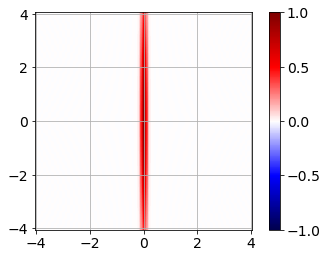

In [52]:
#quick wigner
def wigner(rho, xvec, yvec=None):
     if yvec is None:
        yvec = xvec
     return (np.pi / 2.0) * qt.wigner(rho, xvec, yvec, g=2)
xvec = np.linspace(-4,4,81)
W = wigner(psic, xvec)
yvec = xvec
dx = xvec[1] - xvec[0]
dy = yvec[1] - yvec[0]
extent = (xvec[0] - dx/2.0, xvec[-1] + dx/2.0, yvec[0] - dy/2.0, yvec[-1] + dy/2.0)
plt.imshow(W, origin='lower', extent=extent, cmap='seismic', vmin=-1, vmax=+1, interpolation=None)
plt.colorbar()
plt.grid()

In [53]:
#first, the optimization options.
params = {
'N_blocks' : 8, #number of blocks in circuit
'N_multistart' : 50, #number of optimizations to run in parallel
'epochs' : 200, #number of epochs before termination
'epoch_size' : 10, #number of adam steps per epoch
'learning_rate' : 0.01, #adam learning rate
'term_fid' : 0.999, #terminal fidelitiy
'use_displacements' : False, #use D operators in optimization
'no_CD_end' : False, #set final CD = 0
'dfid_stop' : 1e-6, #stop if dfid between two epochs is smaller than this number
'beta_scale' : 3.0, #maximum |beta| for random initialization
'alpha_scale' : 0.5, #maximum |alpha| for random initialization
'initial_states' : [qt.tensor(qt.basis(2,0),qt.basis(N,0))],
'target_states' : [qt.tensor(qt.basis(2,1), psic)], #end qubit in e since last CD won't have pi pulse.
'name' : 'squeezed state', #name for printing and saving
'filename' : None, 
#if no filename specified, will be saved in this folder with default name #"name.h5" 
'db_val' : db_val, #note: can pass arbitrary parameters, will be saved
}


In [54]:
#create optimization object. 
#Note that initial params will be randomized upon creation
opt = BatchOptimizer(**params)

In [55]:
#print current info. 
opt.print_info()

optimization_type: state transfer
N_multistart: 50
N_blocks: 8
term_fid: 0.999
dfid_stop: 1e-06
no_CD_end: False
learning_rate: 0.01
epoch_size: 10
epochs: 200
beta_scale: 3.0
alpha_scale: 0.5
use_displacements: False
name: squeezed state
comment: 
db_val: 16
N_cav: 150
filename: squeezed state.h5

Best circuit parameters found:
betas:         [-0.01132-0.18236j  0.11614+1.92551j -0.7749 -0.53565j -0.07448+0.60888j
  0.52872+0.54766j  1.88289+0.99449j -0.26108+0.34175j -0.91668-1.16221j]
alphas:        [0.+0.j]
phis (deg):    [  0.      144.57571  22.27202  69.74428 -99.55659 -73.40953  48.02402
  29.08941]
thetas (deg):  [ 45.61991 -63.05299 -78.30299  16.36863  -9.78608 -97.55933 113.36839
 127.25012]
Max Fidelity:  0.157734




In [56]:
#run optimizer.
opt.optimize()
#note that every time an optimizer is run, it will add to the same .h5 file in the filename, saving the data with a new timestamp

Start time: 2021-01-25 20:32:45
 Epoch: 200 / 200 Max Fid: 0.988304 Avg Fid: 0.950375 Max dFid: 0.002512 Avg dFid: 0.000053 Elapsed time: 2:07:32.737141 Remaing time: 0:00:00

Optimization stopped.  Reached maximum number of epochs. Terminal fidelity not reached.

optimization_type: state transfer
N_multistart: 50
N_blocks: 8
term_fid: 0.999
dfid_stop: 1e-06
no_CD_end: False
learning_rate: 0.01
epoch_size: 10
epochs: 200
beta_scale: 3.0
alpha_scale: 0.5
use_displacements: False
name: squeezed state
comment: 
db_val: 16
N_cav: 150
filename: squeezed state.h5

Best circuit parameters found:
betas:         [-0.06458+4.95755j  0.24369-0.71202j -0.54397+5.38979j  0.14454+2.63215j
  0.58924+1.22893j  1.20757+4.38809j  0.10054-0.12403j -0.     -0.j     ]
alphas:        [0.+0.j]
phis (deg):    [   0.        90.00371  -90.00395   90.00885   89.99363  -89.99285
   89.99322 -179.99316]
thetas (deg):  [-90.00068  84.40287 123.08032  43.83674  92.91916  38.94816 -78.04348
  89.99705]
Max Fidelity: 

'2021-01-25 20:32:45'

In [47]:
#now, we can analyze the results.
#note that all data is stored as a timestamp in a .h5 file
#You can also specify which timestamp you are analyzing. Be defult, it will use the most recent optimization in the file.
#I would recommend using "HDFview" software to understand data structure
filename = opt.filename
analysis = OptimizationAnalysis(filename)
analysis.print_info() #we can print info of best circuit

N_blocks: 10
N_cav: 150
N_multistart: 50
alpha_scale: 0.5
beta_scale: 3.0
comment: 
db_val: 18
dfid_stop: 1e-06
elapsed_time_s: 5172.963040590286
epoch_size: 10
epochs: 200
learning_rate: 0.01
name: squeezed state
no_CD_end: False
optimization_type: state transfer
term_fid: 0.999
termination_reason: outside termination
use_displacements: False
filename: squeezed state.h5

Best circuit parameters found:
betas:         [-0.17076-1.80949j -0.55205-0.87159j -1.16549-3.42466j  0.16534-1.60297j
  0.31575+5.41002j -0.15006+1.55174j  0.29914-6.45057j -0.09732-3.5107j
 -0.38636-0.67672j -0.01806+0.01299j]
alphas:        [0.+0.j]
phis (deg):    [  0.      -91.88348  90.90041 -93.51848  91.87106 -85.02099 -93.0329
 -94.02086 -89.26092 179.51929]
thetas (deg):  [  90.0751   -58.2991   -47.00184   70.31905   65.64803  -74.15724
 -119.30694   45.17686  -72.11619  -89.47936]
Max Fidelity:  0.993588




In [48]:
#saving the pulse for the experiment
bc = opt.best_circuit()
print(bc)
betas, alphas, phis, thetas = bc['betas'], bc['alphas'], bc['phis'], bc['thetas']
fname = r'Z:\Data\Tennessee2020\20201201_cooldown\conditional_displacement_circuits\20210123_squeeze_18.npz'
print(fname)
np.savez(fname, betas=betas, phis=phis, thetas=thetas)

{'fidelity': 0.9935887, 'betas': array([-0.17073685-1.8095094j , -0.55204695-0.8716073j ,
       -1.1654547 -3.4243367j ,  0.16530654-1.6028872j ,
        0.31576073+5.4098897j , -0.1500634 +1.5517206j ,
        0.29916042-6.4519386j , -0.09732043-3.5113335j ,
       -0.38635582-0.67623085j, -0.01808998+0.01315927j], dtype=complex64), 'alphas': array([0.+0.j], dtype=complex64), 'phis': array([ 0.       , -1.6037037,  1.5865366, -1.6322657,  1.6034768,
       -1.4837348, -1.6238706, -1.6410694, -1.5578787,  3.133239 ],
      dtype=float32), 'thetas': array([ 1.5720832 , -1.017482  , -0.82033706,  1.2272017 ,  1.1457365 ,
       -1.294508  , -2.0824647 ,  0.78839064, -1.2588286 , -1.5616907 ],
      dtype=float32)}
Z:\Data\Tennessee2020\20201201_cooldown\conditional_displacement_circuits\20210123_squeeze_18.npz


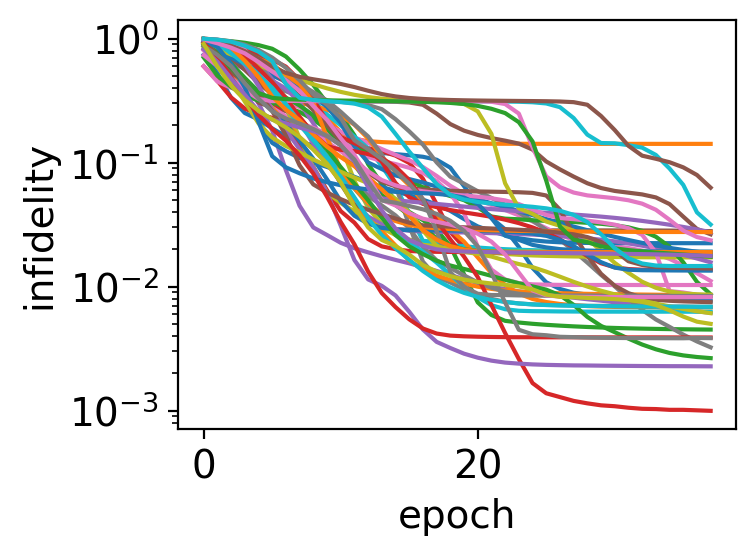

In [17]:
#We can plot the trajectories of the different parallel optimizations
analysis.plot_fidelities()

In [8]:
#We can also load the best circuit, states, and other parameters (see OptimizationAnalysis class)
best_circuit = analysis.best_circuit()
print(best_circuit)
target_state = analysis.target_state()
print(target_state)

{'fidelity': 0.99593514, 'betas': array([ 3.2117655 +1.2233323j , -0.8165957 -0.73543257j,
        0.19942887-0.20403528j,  0.4095894 -1.1010613j ,
       -0.03973835-0.679881j  , -0.300295  +0.36514387j], dtype=complex64), 'alphas': array([ 3.2117655 +1.2233323j , -0.8165957 -0.73543257j,
        0.19942887-0.20403528j,  0.4095894 -1.1010613j ,
       -0.03973835-0.679881j  , -0.300295  +0.36514387j], dtype=complex64), 'phis': array([ 3.2117655 +1.2233323j , -0.8165957 -0.73543257j,
        0.19942887-0.20403528j,  0.4095894 -1.1010613j ,
       -0.03973835-0.679881j  , -0.300295  +0.36514387j], dtype=complex64), 'thetas': array([ 3.2117655 +1.2233323j , -0.8165957 -0.73543257j,
        0.19942887-0.20403528j,  0.4095894 -1.1010613j ,
       -0.03973835-0.679881j  , -0.300295  +0.36514387j], dtype=complex64)}
Quantum object: dims = [[2, 50], [1, 1]], shape = (100, 1), type = ket
Qobj data =
[[ 1.16083086e-01+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j]
 [ 2.46249408e-01+3.28332

In [ ]:
#Now, using the same opt object, we can sweep the number of blocks in the optimization.
sweeper = OptimizationSweeps(opt_object=opt)
sweeper.N_blocks_sweep(min_N_blocks=3, max_N_blocks=6, terminate=True) #"terminate" option specifies if it terminates sweep when term fid is met

In [ ]:
#the sweep data will be nicely saved to the same h5 file. We can analyze the sweep with the sweep analysis class.
sweep_analysis = OptimizationSweepsAnalysis(filename=filename)
sweep_analysis.sweep_names #names of the sweeps it found in the file

In [ ]:
#we can analyze how the best fidelity found depends on the sweep parameter
sweep_analysis.plot_sweep_fidelities(log=False)

In [ ]:
#there are a few other things we can plot. Better data analysis coming soon.
analysis.plot_mag_betas()

In [ ]:
analysis.plot_phase_betas()

In [ ]:
analysis.plot_mag_alphas()

In [ ]:
analysis.plot_phase_alphas()

In [ ]:
analysis.plot_average_magnitude_alpha()

In [ ]:
analysis.plot_average_magnitude_beta()

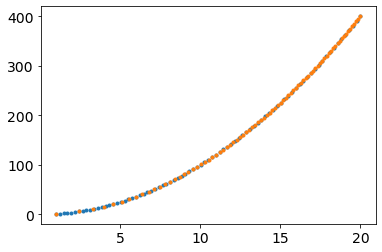

In [15]:
xs = np.linspace(1,20,81)
plt.plot(xs, xs**2, '.')
xs2 = np.sqrt(np.linspace(xs[0]**2, xs[-1]**2, len(xs)))
plt.plot(xs2, xs2**2, '.')